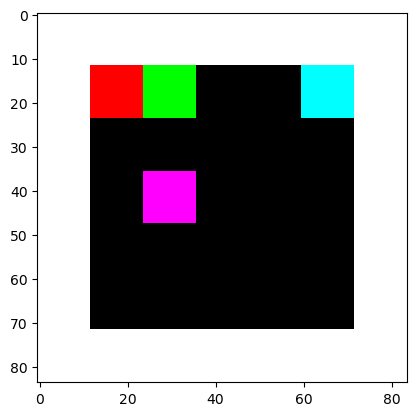

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from agent import *
from selection import *
from utils import *
from component.env import Environment, StochasticGameEnvironment
from simulation import *
from main import Config
from tqdm import tqdm
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import ticker

In [4]:
seed_everything()
config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.995,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 5,
    'select_h': 5,
    'state_repr': 'bi',
    'batch_size': 64,
    'learning_rate': 1e-3,
}
torch.cuda.is_available()

True

In [2]:
def check_convergence(agents: dict[int, object], thresh: tuple, k: int, last_reward: dict[int, float]):
    strategy_convergent_episode = {}
    reward_convergent_episode = {}
    thresh_strategy, thresh_reward = thresh[0], thresh[1]

    for n in agents:
        # Strategy convergence
        strategy_convergent = agents[n].determine_convergence(thresh_strategy, k)
        if strategy_convergent:
            strategy_convergent_episode[n] = agents[n].play_times

        # reward convergence
        if np.abs(agents[n].running_score-last_reward[n]) <= thresh_reward:
            reward_convergent_episode[n] = agents[n].play_times

    return strategy_convergent_episode, reward_convergent_episode

# <center>Prisoner's Dilemma<center>

In [163]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)
k = 1000
config['h'] = 5
config['n_episodes'] = 30000  # convergent threshold
config['epsilon_decay'] = 0.995
thresh_strategy = k * config['min_epsilon'] + 5
thresh_network = k/100
thresh_reward = 1
thresh = (thresh_strategy, thresh_reward, thresh_network)

### DRQN

In [5]:
df_normal_pd = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            with HiddenPrints():
                env.play(agent1, agent2, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_normal_pd.loc[len(df_normal_pd.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

100it [1:44:48, 62.89s/it]


### Alternative DRQN

In [6]:
df_alter_pd = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            TwoAgentSimulation.two_agent_alter_learning(agent1, agent2, config_obj, env, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_alter_pd.loc[len(df_alter_pd.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

100it [58:27, 35.07s/it]


### Episodic DRQN

In [164]:
df_episodic_pd_20 = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                       'agent2_strategy', 'agent2_reward', 
                                       'temptation', 'reward', 'punishment', 'sucker', 
                                       'agent1_final_strategy', 'agent1_defection_ratio',
                                       'agent2_final_strategy', 'agent2_defection_ratio',
                                       'agent1_updating_times', 'agent2_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config['epsilon_decay'] = 0.99
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.005, update_times=20, episodic_flag=True, sg_flag=False)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_episodic_pd_20.loc[len(df_episodic_pd_20.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            agents[0].updating_times[1], agents[1].updating_times[0]]

100it [56:26, 33.86s/it]


In [116]:
df_episodic_pd = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                       'agent2_strategy', 'agent2_reward', 
                                       'temptation', 'reward', 'punishment', 'sucker', 
                                       'agent1_final_strategy', 'agent1_defection_ratio',
                                       'agent2_final_strategy', 'agent2_defection_ratio',
                                       'agent1_updating_times', 'agent2_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config['epsilon_decay'] = 0.995
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.015, update_times=10, episodic_flag=True, sg_flag=False)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_episodic_pd.loc[len(df_episodic_pd.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            agents[0].updating_times[1], agents[1].updating_times[0]]

100it [1:14:40, 44.81s/it]


In [151]:
df_episodic_pd[df_episodic_pd.isna().any(axis=1)]

,agent1_strategy,agent1_reward,agent2_strategy,agent2_reward,temptation,reward,punishment,sucker,agent1_final_strategy,agent1_defection_ratio,agent2_final_strategy,agent2_defection_ratio,agent1_updating_times,agent2_updating_times,game,model
33,29402.0,NaN,NaN,29402.0,1.23,1.0,0.0,-0.06,1.0,0.944902,0.0,0.541256,3380.0,3380.0,PD,episodic
82,22558.0,27447.0,NaN,27447.0,2.52,1.0,0.0,-0.67,1.0,0.941126,1.0,0.922216,3380.0,3380.0,PD,episodic
88,27447.0,NaN,NaN,29402.0,1.50,1.0,0.0,-0.12,1.0,0.704204,1.0,0.897456,3380.0,3380.0,PD,episodic
95,22558.0,28423.0,NaN,27447.0,1.40,1.0,0.0,-0.51,1.0,0.916060,1.0,0.890416,3380.0,3380.0,PD,episodic


In [292]:
df_normal_pd['agent1_updating_times'] = df_normal_pd[['agent1_strategy','agent1_reward']].max(axis=1) - config['batch_size']
df_normal_pd['agent2_updating_times'] = df_normal_pd[['agent2_strategy','agent2_reward']].max(axis=1) - config['batch_size']
df_alter_pd['agent1_updating_times'] = (df_alter_pd[['agent1_strategy','agent1_reward']].max(axis=1))/4
df_alter_pd['agent2_updating_times'] = (df_alter_pd[['agent2_strategy','agent2_reward']].max(axis=1))/4
df_normal_pd['model'] = 'normal'
df_alter_pd['model'] = 'alternate'
df_episodic_pd['model'] = 'episodic'
df_pd = pd.concat([df_normal_pd, df_alter_pd],ignore_index=True)
df_pd = pd.concat([df_pd, df_episodic_pd],ignore_index=True)
df_pd.to_csv('2_agent_pd.csv',index=False)

In [190]:
df_pd = pd.read_csv('data/csv/2_agent_pd.csv')
df_pd[df_pd.isna().any(axis=1)]
df_pd_plot = df_pd.copy()
df_pd_plot = df_pd_plot.loc[df_pd_plot.model != 'episodic']
df_episodic_pd['model'] = 'episodic'
df_pd_plot = pd.concat([df_pd_plot, df_episodic_pd], ignore_index=True)

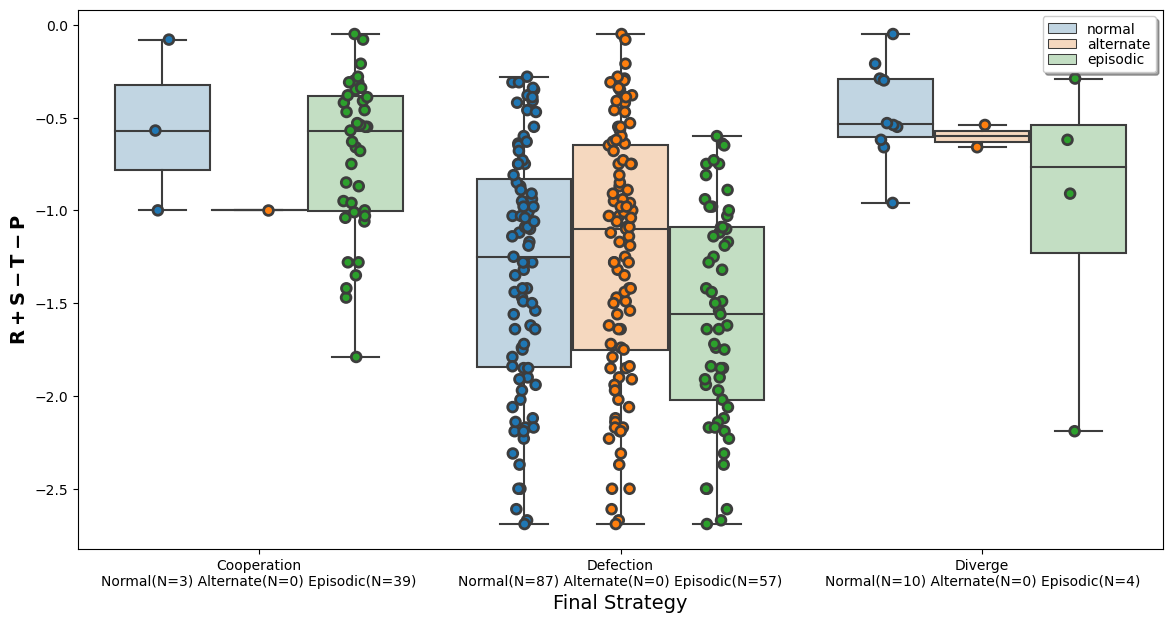

In [184]:
df_pd_plot.loc[df_pd_plot.agent1_reward.isnull(), 'agent1_final_strategy'] = np.inf
df_pd_plot.loc[df_pd_plot.agent1_strategy.isnull(), 'agent1_final_strategy'] = np.inf
df_pd_plot.loc[df_pd_plot.agent2_strategy.isnull(), 'agent1_final_strategy'] = np.inf

df_pd_plot.loc[df_pd_plot.agent2_reward.isnull(), 'agent2_final_strategy'] = np.inf
df_pd_plot.loc[df_pd_plot.agent2_strategy.isnull(), 'agent2_final_strategy'] = np.inf
df_pd_plot.loc[df_pd_plot.model == 'alternative', 'model'] = 'alternate'

df_pd_plot.temptation = df_pd_plot.temptation/df_pd_plot.reward
df_pd_plot.sucker = df_pd_plot.sucker/df_pd_plot.reward
df_pd_plot['new_reward'] = 1.0
df_pd_plot['R+S-T-P'] = df_pd_plot['reward'] + df_pd_plot['sucker'] - df_pd_plot['temptation'] - df_pd_plot['punishment']

plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_pd_plot, x="agent1_final_strategy", y="R+S-T-P", hue="model")
# for violin, alpha in zip(ax.collections[::2], [0.7,0.7,0.7,0.7,0.7,0.7]):
#     violin.set_alpha(alpha)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent1_final_strategy', y = 'R+S-T-P',  hue='model', data = df_pd_plot, marker='o',
              size=7, linewidth=2, dodge=True)

plt.xlim(-0.5,2.5)

df_pd_plot_noraml = df_pd_plot.loc[df_pd_plot.model=='normal']
df_pd_plot_altern = df_pd_plot.loc[df_pd_plot.model=='alternative']
df_pd_plot_episod = df_pd_plot.loc[df_pd_plot.model=='episodic']
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==0)}) Alternate(N={sum(df_pd_plot_altern['agent1_final_strategy']==0)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==1)}) Alternate(N={sum(df_pd_plot_altern['agent1_final_strategy']==1)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==1)})", 
                    f"Diverge\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==np.inf)}) Alternate(N={sum(df_pd_plot_altern['agent1_final_strategy']==np.inf)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==np.inf)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{R+S-T-P}$', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

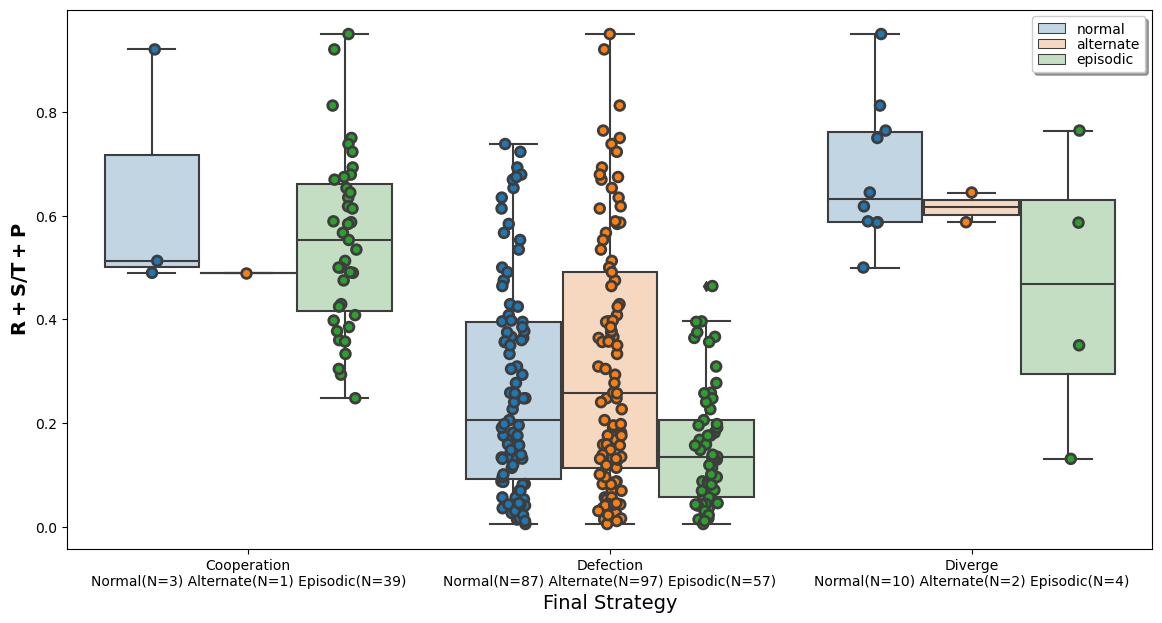

In [180]:
df_pd_plot['R+S/T+P'] = (df_pd_plot['reward'] + df_pd_plot['sucker']) / ( df_pd_plot['temptation'] + df_pd_plot['punishment'])

plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_pd_plot, x="agent1_final_strategy", y="R+S/T+P", hue="model")
# for violin, alpha in zip(ax.collections[::2], [0.7,0.7,0.7,0.7,0.7,0.7]):
#     violin.set_alpha(alpha)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent1_final_strategy', y = 'R+S/T+P',  hue='model', data = df_pd_plot, marker='o',
              size=7, linewidth=2, dodge=True)

plt.xlim(-0.5,2.5)

df_pd_plot_noraml = df_pd_plot.loc[df_pd_plot.model=='normal']
df_pd_plot_altern = df_pd_plot.loc[df_pd_plot.model=='alternate']
df_pd_plot_episod = df_pd_plot.loc[df_pd_plot.model=='episodic']
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==0)}) Alternate(N={sum(df_pd_plot_altern['agent1_final_strategy']==0)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==1)}) Alternate(N={sum(df_pd_plot_altern['agent1_final_strategy']==1)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==1)})", 
                    f"Diverge\nNormal(N={sum(df_pd_plot_noraml['agent1_final_strategy']==np.inf)}) Alternate(N={sum(df_pd_plot_altern['agent1_final_strategy']==np.inf)}) Episodic(N={sum(df_pd_plot_episod['agent1_final_strategy']==np.inf)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{R+S/T+P}$', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

/ufs/haohui/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


posx and posy should be finite values
posx and posy should be finite values


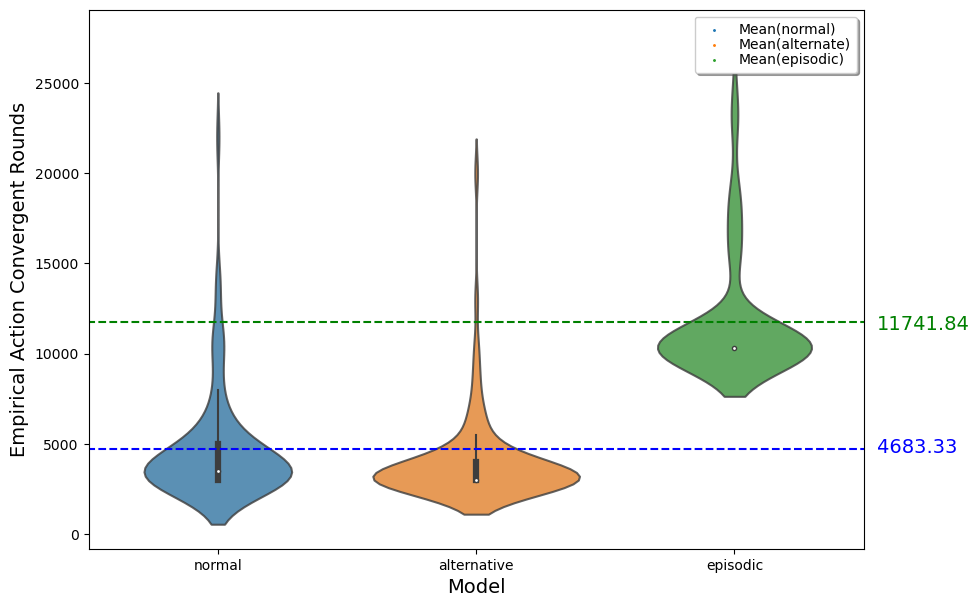

In [192]:
df_pd_plot['game'] = 'PD'
df_pd_plot['strategy_episode'] = (df_pd_plot['agent1_strategy'] + df_pd_plot['agent2_strategy'])/2
df_pd_plot['reward_episode'] = (df_pd_plot['agent1_reward'] + df_pd_plot['agent2_reward'])/2
df_pd_plot.dropna(inplace=True)

plt.figure(figsize=(10, 7))
ax = sns.violinplot(data=df_pd_plot, x="model", y="strategy_episode")
# sns.violinplot(data=df_pd_plot, x="model", y="reward_episode")

for violin, alpha in zip(ax.collections[::2], [0.8,0.8,0.8,0.8,0.8,0.8]):
    violin.set_alpha(alpha)
plt.hlines(np.mean(df_pd_plot.loc[df_pd_plot.model=='normal', 'strategy_episode']), -1, 4, 'blue', '--', label='Mean(normal)')
plt.hlines(np.mean(df_pd_plot.loc[df_pd_plot.model=='alternate', 'strategy_episode']), -1, 4, 'orange', '--', label='Mean(alternate)')
plt.hlines(np.mean(df_pd_plot.loc[df_pd_plot.model=='episodic', 'strategy_episode']), -1, 4, 'green', '--', label='Mean(episodic)')
plt.text(2.55, np.mean(df_pd_plot.loc[df_pd_plot.model=='normal', 'strategy_episode'])-200, f"{round(np.mean(df_pd_plot.loc[df_pd_plot.model=='normal', 'strategy_episode']),2)}", c='blue', fontsize=14)
plt.text(2.55, np.mean(df_pd_plot.loc[df_pd_plot.model=='alternate', 'strategy_episode'])-600, f"{round(np.mean(df_pd_plot.loc[df_pd_plot.model=='alternate', 'strategy_episode']),2)}", c='orange', fontsize=14)
plt.text(2.55, np.mean(df_pd_plot.loc[df_pd_plot.model=='episodic', 'strategy_episode'])-400, f"{round(np.mean(df_pd_plot.loc[df_pd_plot.model=='episodic', 'strategy_episode']),2)}", c='green', fontsize=14)
plt.xlim(-0.5,2.5)

xticks_list = []
xticklabels_list = []
for i in ax.get_xticklabels():
    try:
        xticks_list.append(i.get_position()[0])
        xticklabels_list.append(int(float(i.get_text())))
    except: 
        xticklabels_list.append(i.get_text())
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticklabels_list)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Empirical Action Convergent Rounds', fontsize=14)
ines, labels = ax.get_legend_handles_labels()
plt.legend(lines[-3:], labels[-3:], loc='upper left', scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

Text(0, 0.5, 'Update Times ($log_{10}$)')

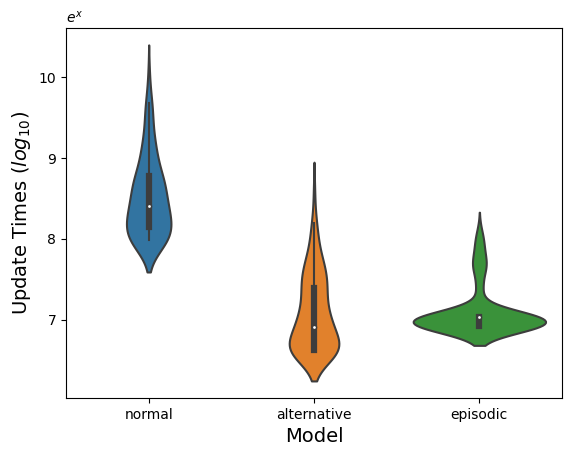

In [193]:
df_pd_plot['update_times'] = np.log((df_pd_plot['agent1_updating_times'] + df_pd_plot['agent2_updating_times'])/2)
ax = sns.violinplot(data=df_pd_plot, x="model", y="update_times")
plt.text(-.0, 1.05, '$e^x$', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Update Times ($log_{10}$)', fontsize=14)

# <center>Stag Hunt<center>

In [273]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)
k = 1000
config['h'] = 5
config['n_episodes'] = 30000  # convergent threshold
config['epsilon_decay'] = 0.995
thresh_strategy = k * config['min_epsilon'] + 5
thresh_network = k/100
thresh_reward = 1.5
thresh = (thresh_strategy, thresh_reward, thresh_network)

### DRQN

In [10]:
df_normal_sh = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            with HiddenPrints():
                env.play(agent1, agent2, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_normal_sh.loc[len(df_normal_sh.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

100it [1:07:35, 40.55s/it]


### Alternative DRQN

In [11]:
df_alter_sh = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            TwoAgentSimulation.two_agent_alter_learning(agent1, agent2, config_obj, env, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_alter_sh.loc[len(df_alter_sh.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

100it [49:07, 29.48s/it]


### Episodic DRQN

In [274]:
df_episodic_sh = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent1_updating_times', 'agent2_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    config['epsilon_decay'] = 0.995
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.015, update_times=10, episodic_flag=True, sg_flag=False)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_episodic_sh.loc[len(df_episodic_sh.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            agents[0].updating_times[1], agents[1].updating_times[0]]

100it [58:11, 34.92s/it]


In [297]:
df_normal_sh['agent1_updating_times'] = df_normal_sh[['agent1_strategy','agent1_reward']].max(axis=1) - config['batch_size']
df_normal_sh['agent2_updating_times'] = df_normal_sh[['agent2_strategy','agent2_reward']].max(axis=1) - config['batch_size']
df_alter_sh['agent1_updating_times'] = (df_alter_sh[['agent1_strategy','agent1_reward']].max(axis=1))/4
df_alter_sh['agent2_updating_times'] = (df_alter_sh[['agent2_strategy','agent2_reward']].max(axis=1))/4
df_normal_sh['model'] = 'normal'
df_alter_sh['model'] = 'alternative'
df_episodic_sh['model'] = 'episodic'
df_sh = pd.concat([df_normal_sh, df_alter_sh],ignore_index=True)
df_sh = pd.concat([df_sh, df_episodic_sh],ignore_index=True)
df_sh.to_csv('2_agent_sh.csv',index=False)

In [228]:
df_sh = pd.read_csv('data/csv/2_agent_sh.csv')
df_episodic_sh[df_episodic_sh.isna().any(axis=1)]

,agent1_strategy,agent1_reward,agent2_strategy,agent2_reward,temptation,reward,punishment,sucker,agent1_final_strategy,agent1_defection_ratio,agent2_final_strategy,agent2_defection_ratio,agent1_updating_times,agent2_updating_times


In [275]:
df_sh_plot = df_sh.copy()
df_sh_plot = df_sh_plot.loc[df_sh_plot.model != 'episodic']
df_episodic_sh['model'] = 'episodic'
df_sh_plot = pd.concat([df_sh_plot, df_episodic_sh], ignore_index=True)

In [276]:
# df_sh_plot = df_sh.copy()
df_sh_plot = df_sh_plot.astype({'agent1_strategy':'int', 'agent1_reward':'int', 
                              'agent2_strategy':'int', 'agent2_reward':'int', 
                              'agent1_updating_times':'int', 'agent2_updating_times':'int'})
# df_sh_plot.temptation = df_sh_plot.temptation/df_sh_plot.reward
# df_sh_plot.sucker = df_sh_plot.sucker/df_sh_plot.reward
# df_sh_plot['new_reward'] = 1.0

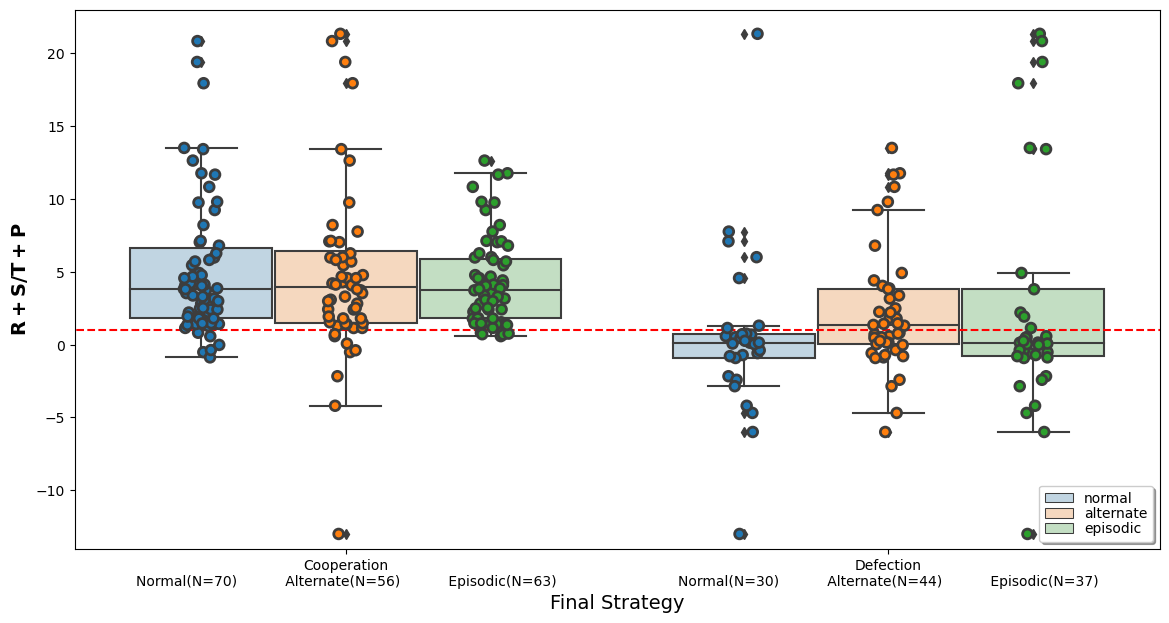

In [277]:
df_sh_plot['R+S/T+P'] = (df_sh_plot['reward'] + df_sh_plot['sucker']) / (df_sh_plot['temptation'] + df_sh_plot['punishment'])
df_sh_plot.loc[df_sh_plot.model == 'alternative', 'model'] = 'alternate'

df_sh_plot_noraml = df_sh_plot.loc[df_sh_plot.model=='normal']
df_sh_plot_altern = df_sh_plot.loc[df_sh_plot.model=='alternate']
df_sh_plot_episod = df_sh_plot.loc[df_sh_plot.model=='episodic']

plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_sh_plot, x="agent1_final_strategy", y="R+S/T+P", hue="model")
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent1_final_strategy', y = 'R+S/T+P',  hue='model', data = df_sh_plot, marker='o',
              size=7, linewidth=2, dodge=True)
plt.hlines(1, -10, 10, 'red', '--')
plt.xlim(-0.5,1.5)
plt.ylim(-14,23)

ax.set_xticks([0, 1])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_sh_plot_noraml['agent1_final_strategy']==0)})           Alternate(N={sum(df_sh_plot_altern['agent1_final_strategy']==0)})           Episodic(N={sum(df_sh_plot_episod['agent1_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_sh_plot_noraml['agent1_final_strategy']==1)})           Alternate(N={sum(df_sh_plot_altern['agent1_final_strategy']==1)})           Episodic(N={sum(df_sh_plot_episod['agent1_final_strategy']==1)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{R+S/T+P}$', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], loc='lower right', scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)


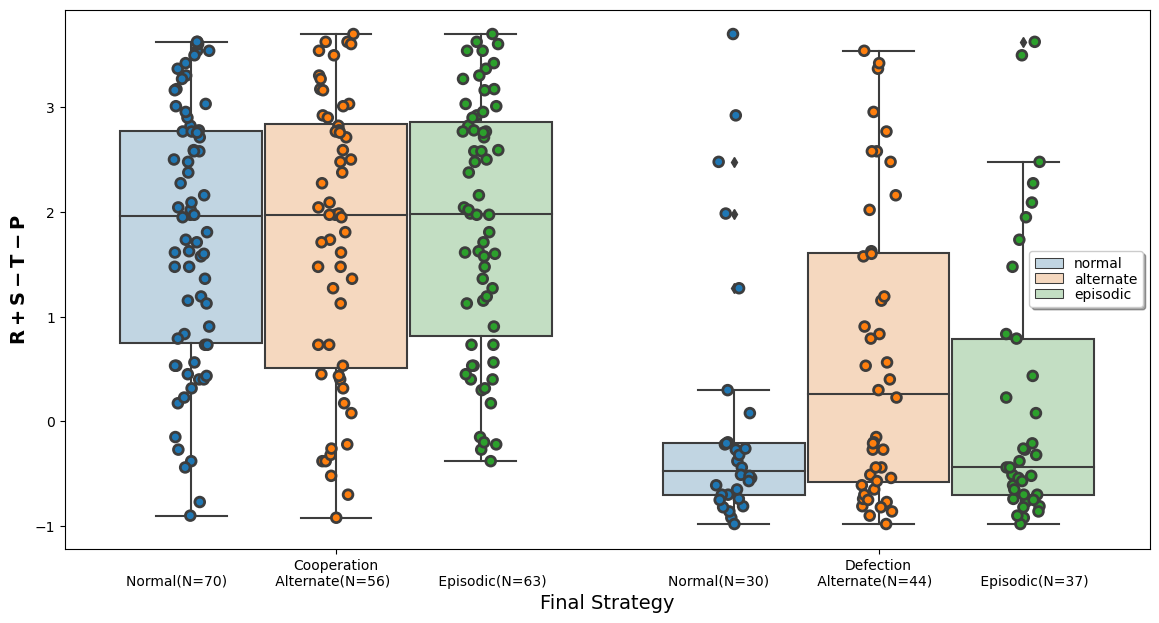

In [242]:
# df_sh_plot = df_sh.copy()
df_sh_plot.temptation = df_sh_plot.temptation/df_sh_plot.reward
df_sh_plot.sucker = df_sh_plot.sucker/df_sh_plot.reward
df_sh_plot['new_reward'] = 1.0
df_sh_plot['R+S-T-P'] = df_sh_plot['reward'] + df_sh_plot['sucker'] - df_sh_plot['temptation'] - df_sh_plot['punishment']
df_sh_plot_noraml = df_sh_plot.loc[df_sh_plot.model=='normal']
df_sh_plot_altern = df_sh_plot.loc[df_sh_plot.model=='alternate']
df_sh_plot_episod = df_sh_plot.loc[df_sh_plot.model=='episodic']

plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_sh_plot, x="agent1_final_strategy", y="R+S-T-P", hue="model")
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent1_final_strategy', y = 'R+S-T-P',  hue='model', data = df_sh_plot, marker='o',
              size=7, linewidth=2, dodge=True)
plt.xlim(-0.5,1.5)
ax.set_xticks([0, 1])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_sh_plot_noraml['agent1_final_strategy']==0)})           Alternate(N={sum(df_sh_plot_altern['agent1_final_strategy']==0)})           Episodic(N={sum(df_sh_plot_episod['agent1_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_sh_plot_noraml['agent1_final_strategy']==1)})           Alternate(N={sum(df_sh_plot_altern['agent1_final_strategy']==1)})           Episodic(N={sum(df_sh_plot_episod['agent1_final_strategy']==1)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{R+S-T-P}$', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)


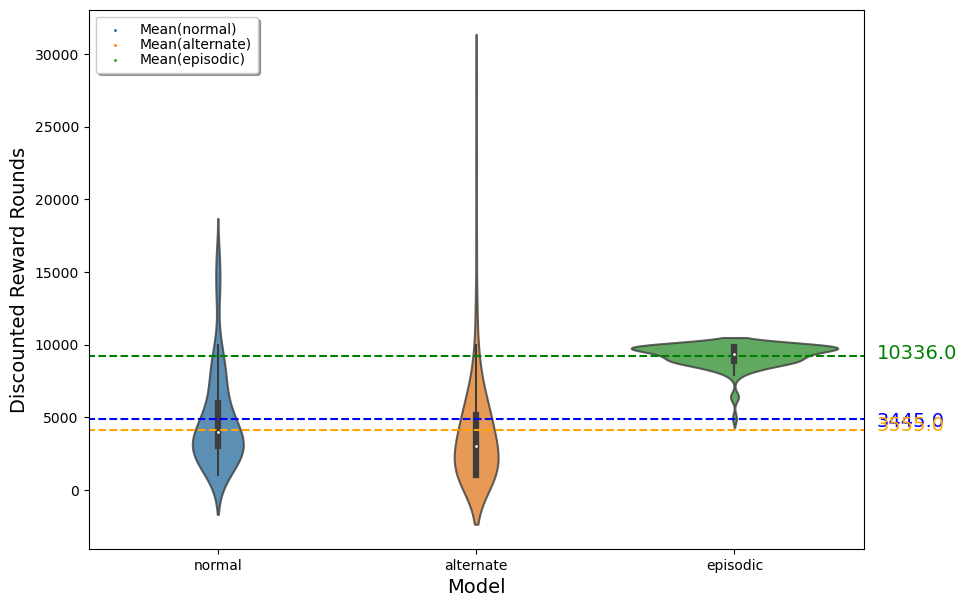

In [280]:
df_sh_plot['strategy_episode'] = (df_sh_plot['agent1_strategy'] + df_sh_plot['agent2_strategy'])/2
df_sh_plot['reward_episode'] = (df_sh_plot['agent1_reward'] + df_sh_plot['agent2_reward'])/2

plt.figure(figsize=(10, 7))
ax = sns.violinplot(data=df_sh_plot, x="model", y="reward_episode")
# sns.violinplot(data=df_pd_plot, x="model", y="reward_episode")

for violin, alpha in zip(ax.collections[::2], [0.8,0.8,0.8,0.8,0.8,0.8]):
    violin.set_alpha(alpha)
plt.hlines(np.mean(df_sh_plot.loc[df_sh_plot.model=='normal', 'reward_episode']), -1, 4, 'blue', '--', label='Mean(normal)')
plt.hlines(np.mean(df_sh_plot.loc[df_sh_plot.model=='alternate', 'reward_episode']), -1, 4, 'orange', '--', label='Mean(alternate)')
plt.hlines(np.mean(df_sh_plot.loc[df_sh_plot.model=='episodic', 'reward_episode']), -1, 4, 'green', '--', label='Mean(episodic)')
plt.text(2.55, np.mean(df_sh_plot.loc[df_sh_plot.model=='normal', 'reward_episode'])-500, f"{round(np.mean(df_sh_plot.loc[df_sh_plot.model=='normal', 'strategy_episode']),2)}", c='blue', fontsize=14)
plt.text(2.55, np.mean(df_sh_plot.loc[df_sh_plot.model=='alternate', 'reward_episode']), f"{round(np.mean(df_sh_plot.loc[df_sh_plot.model=='alternate', 'strategy_episode']),2)}", c='orange', fontsize=14)
plt.text(2.55, np.mean(df_sh_plot.loc[df_sh_plot.model=='episodic', 'reward_episode'])-200, f"{round(np.mean(df_sh_plot.loc[df_sh_plot.model=='episodic', 'strategy_episode']),2)}", c='green', fontsize=14)
plt.xlim(-0.5,2.5)

xticks_list = []
xticklabels_list = []
for i in ax.get_xticklabels():
    try:
        xticks_list.append(i.get_position()[0])
        xticklabels_list.append(int(float(i.get_text())))
    except: 
        xticklabels_list.append(i.get_text())
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticklabels_list)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Discounted Reward Rounds', fontsize=14)
ines, labels = ax.get_legend_handles_labels()
plt.legend(lines[-3:], labels[-3:], loc='upper left', scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

Text(0, 0.5, 'Update Times ($log_{10}$)')

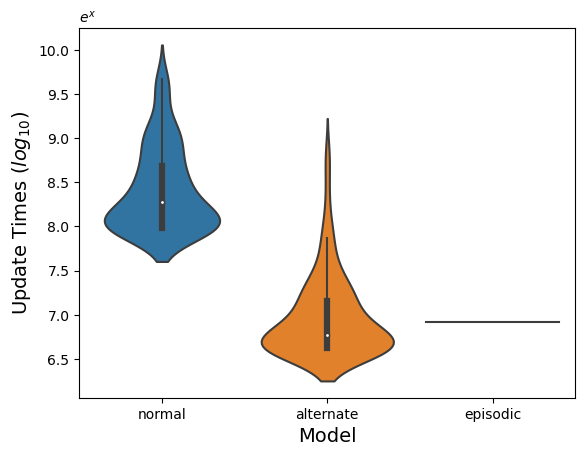

In [281]:
# df_pd_plot['update_times'] = (df_pd_plot['agent1_updating_times'] + df_pd_plot['agent2_updating_times'])/2
df_sh_plot['update_times'] = np.log((df_sh_plot['agent1_updating_times'] + df_sh_plot['agent2_updating_times'])/2)
df_sh_plot_new = df_sh_plot[df_sh_plot['update_times'].map(df_sh_plot['update_times'].value_counts()) > 2]
ax = sns.violinplot(data=df_sh_plot, x="model", y="update_times")
# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True) 
# formatter.set_powerlimits((-1,1)) 
# ax.yaxis.set_major_formatter(formatter) 
plt.text(-.0, 1.05, '$e^x$', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Update Times ($log_{10}$)', fontsize=14)

# EDA

In [319]:
func = np.mean
print('Normal DRQN')
print(f"PD: Empirical Mean: Agent1:{round(func(df_normal_pd['agent1_strategy']),4)}, Agent2: {round(func(df_normal_pd['agent2_strategy']),4)}")
print(f"PD: Reward    Mean: Agent1:{round(func(df_normal_pd['agent1_reward']),4)}, Agent2: {round(func(df_normal_pd['agent2_reward']),4)}")
print(f"PD: Update    Mean: Agent1:{round(func(df_normal_pd['agent1_updating_times']),4)}, Agent2: {round(func(df_normal_pd['agent2_updating_times']),4)}")
print(f"SH: Empirical Mean: Agent1:{round(func(df_normal_sh['agent1_strategy']),4)}, Agent2: {round(func(df_normal_sh['agent2_strategy']),4)}")
print(f"SH: Reward    Mean: Agent1:{round(func(df_normal_sh['agent1_reward']),4)}, Agent2: {round(func(df_normal_sh['agent2_reward']),4)}")
print(f"SH: Update    Mean: Agent1:{round(func(df_normal_sh['agent1_updating_times']),4)}, Agent2: {round(func(df_normal_sh['agent2_updating_times']),4)}")

print()
print('Alternative DRQN')
print(f"PD: Empirical Mean: Agent1:{round(func(df_alter_pd['agent1_strategy']),4)}, Agent2: {round(func(df_alter_pd['agent2_strategy']),4)}")
print(f"PD: Reward    Mean: Agent1:{round(func(df_alter_pd['agent1_reward']),4)}, Agent2: {round(func(df_alter_pd['agent2_reward']),4)}")
print(f"PD: Update    Mean: Agent1:{round(func(df_alter_pd['agent1_updating_times']),4)}, Agent2: {round(func(df_alter_pd['agent2_updating_times']),4)}")
print(f"SH: Empirical Mean: Agent1:{round(func(df_alter_sh['agent1_strategy']),4)}, Agent2: {round(func(df_alter_sh['agent2_strategy']),4)}")
print(f"SH: Reward    Mean: Agent1:{round(func(df_alter_sh['agent1_reward']),4)}, Agent2: {round(func(df_alter_sh['agent2_reward']),4)}")
print(f"SH: Update    Mean: Agent1:{round(func(df_alter_sh['agent1_updating_times']),4)}, Agent2: {round(func(df_alter_sh['agent2_updating_times']),4)}")

print()
print('Episodic DRQN')
print(f"PD: Empirical Mean: Agent1:{round(func(df_episodic_pd['agent1_strategy']),4)}, Agent2: {round(func(df_episodic_pd['agent2_strategy']),4)}")
print(f"PD: Reward    Mean: Agent1:{round(func(df_episodic_pd['agent1_reward']),4)}, Agent2: {round(func(df_episodic_pd['agent2_reward']),4)}")
print(f"PD: Update    Mean: Agent1:{round(func(df_episodic_pd['agent1_updating_times']),4)}, Agent2: {round(func(df_episodic_pd['agent2_updating_times']),4)}")
print(f"SH: Empirical Mean: Agent1:{round(func(df_episodic_sh['agent1_strategy']),4)}, Agent2: {round(func(df_episodic_sh['agent2_strategy']),4)}")
print(f"SH: Reward    Mean: Agent1:{round(func(df_episodic_sh['agent1_reward']),4)}, Agent2: {round(func(df_episodic_sh['agent2_reward']),4)}")
print(f"SH: Update    Mean: Agent1:{round(func(df_episodic_sh['agent1_updating_times']),4)}, Agent2: {round(func(df_episodic_sh['agent2_updating_times']),4)}")


Normal DRQN
PD: Empirical Mean: Agent1:4890.1099, Agent2: 4755.5556
PD: Reward    Mean: Agent1:5266.6667, Agent2: 5571.4286
PD: Update    Mean: Agent1:6001.9341, Agent2: 5979.956
SH: Empirical Mean: Agent1:3540.0, Agent2: 3350.0
SH: Reward    Mean: Agent1:4880.0, Agent2: 4860.0
SH: Update    Mean: Agent1:5186.0, Agent2: 5136.0

Alternative DRQN
PD: Empirical Mean: Agent1:4333.3333, Agent2: 3785.7143
PD: Reward    Mean: Agent1:4581.6327, Agent2: 5290.0
PD: Update    Mean: Agent1:1376.2626, Agent2: 1467.5
SH: Empirical Mean: Agent1:3690.0, Agent2: 3420.0
SH: Reward    Mean: Agent1:4100.0, Agent2: 4080.0
SH: Update    Mean: Agent1:1235.0, Agent2: 1235.0

Episodic DRQN
PD: Empirical Mean: Agent1:8516.2041, Agent2: 8346.2062
PD: Reward    Mean: Agent1:9387.4433, Agent2: 9480.2268
PD: Update    Mean: Agent1:775.0, Agent2: 775.0
SH: Empirical Mean: Agent1:7826.0, Agent2: 8166.0
SH: Reward    Mean: Agent1:9486.0, Agent2: 9316.0
SH: Update    Mean: Agent1:729.8, Agent2: 729.8


In [272]:
func = np.mean
print('Episodic DRQN')
print(f"PD: Empirical Mean: Agent1:{round(func(df_episodic_pd['agent1_strategy']),4)}, Agent2: {round(func(df_episodic_pd['agent2_strategy']),4)}")
print(f"PD: Reward    Mean: Agent1:{round(func(df_episodic_pd['agent1_reward']),4)}, Agent2: {round(func(df_episodic_pd['agent2_reward']),4)}")
print(f"PD: Update    Mean: Agent1:{round(func(df_episodic_pd['agent1_updating_times']),4)}, Agent2: {round(func(df_episodic_pd['agent2_updating_times']),4)}")
print(f"SH: Empirical Mean: Agent1:{round(func(df_episodic_sh['agent1_strategy']),4)}, Agent2: {round(func(df_episodic_sh['agent2_strategy']),4)}")
print(f"SH: Reward    Mean: Agent1:{round(func(df_episodic_sh['agent1_reward']),4)}, Agent2: {round(func(df_episodic_sh['agent2_reward']),4)}")
print(f"SH: Update    Mean: Agent1:{round(func(df_episodic_sh['agent1_updating_times']),4)}, Agent2: {round(func(df_episodic_sh['agent2_updating_times']),4)}")
print()
print(f"PD: Sample efficiency: Agent1:{round(func(np.max(df_episodic_pd[['agent1_strategy','agent1_reward']], axis=1)/df_episodic_pd['agent1_updating_times']),4)}, Agent2: {round(func(np.max(df_episodic_pd[['agent2_strategy','agent2_reward']], axis=1)/df_episodic_pd['agent2_updating_times']),4)}")
print(f"SH: Sample efficiency: Agent1:{round(func(np.max(df_episodic_sh[['agent1_strategy','agent1_reward']], axis=1)/df_episodic_sh['agent1_updating_times']),4)}, Agent2: {round(func(np.max(df_episodic_sh[['agent2_strategy','agent2_reward']], axis=1)/df_episodic_sh['agent2_updating_times']),4)}")

Episodic DRQN
PD: Empirical Mean: Agent1:12468.17, Agent2: 11558.1354
PD: Reward    Mean: Agent1:12611.449, Agent2: 12457.64
PD: Update    Mean: Agent1:1355.0, Agent2: 1355.0
SH: Empirical Mean: Agent1:10208.08, Agent2: 10463.92
SH: Reward    Mean: Agent1:8841.09, Agent2: 8724.41
SH: Update    Mean: Agent1:1010.0, Agent2: 1010.0

PD: Sample efficiency: Agent1:9.9379, Agent2: 10.0154
SH: Sample efficiency: Agent1:10.107, Agent2: 10.3603


In [510]:
print('Normal DRQN')
print(f"PD: Sample efficiency: Agent1:{round(func(np.max(df_normal_pd[['agent1_strategy','agent1_reward']], axis=1)/df_normal_pd['agent1_updating_times']),4)}, Agent2: {round(func(np.max(df_normal_pd[['agent2_strategy','agent2_reward']], axis=1)/df_normal_pd['agent2_updating_times']),4)}")
print(f"SH: Sample efficiency: Agent1:{round(func(np.max(df_normal_sh[['agent1_strategy','agent1_reward']], axis=1)/df_normal_sh['agent1_updating_times']),4)}, Agent2: {round(func(np.max(df_normal_sh[['agent2_strategy','agent2_reward']], axis=1)/df_normal_sh['agent2_updating_times']),4)}")

print()
print('Alternative DRQN')
print(f"PD: Sample efficiency: Agent1:{round(func(np.max(df_alter_pd[['agent1_strategy','agent1_reward']], axis=1)/df_alter_pd['agent1_updating_times']),4)}, Agent2: {round(func(np.max(df_alter_pd[['agent2_strategy','agent2_reward']], axis=1)/df_alter_pd['agent2_updating_times']),4)}")
print(f"SH: Sample efficiency: Agent1:{round(func(np.max(df_alter_sh[['agent1_strategy','agent1_reward']], axis=1)/df_alter_sh['agent1_updating_times']),4)}, Agent2: {round(func(np.max(df_alter_sh[['agent2_strategy','agent2_reward']], axis=1)/df_alter_sh['agent2_updating_times']),4)}")

print()
print('Episodic DRQN')
print(f"PD: Sample efficiency: Agent1:{round(func(np.max(df_episodic_pd[['agent1_strategy','agent1_reward']], axis=1)/df_episodic_pd['agent1_updating_times']),4)}, Agent2: {round(func(np.max(df_episodic_pd[['agent2_strategy','agent2_reward']], axis=1)/df_episodic_pd['agent2_updating_times']),4)}")
print(f"SH: Sample efficiency: Agent1:{round(func(np.max(df_episodic_sh[['agent1_strategy','agent1_reward']], axis=1)/df_episodic_sh['agent1_updating_times']),4)}, Agent2: {round(func(np.max(df_episodic_sh[['agent2_strategy','agent2_reward']], axis=1)/df_episodic_sh['agent2_updating_times']),4)}")


Normal DRQN
PD: Sample efficiency: Agent1:1.0141, Agent2: 1.0141
SH: Sample efficiency: Agent1:1.0158, Agent2: 1.0156

Alternative DRQN
PD: Sample efficiency: Agent1:4.0, Agent2: 4.0
SH: Sample efficiency: Agent1:4.0, Agent2: 4.0

Episodic DRQN
PD: Sample efficiency: Agent1:13.5351, Agent2: 13.6428
SH: Sample efficiency: Agent1:13.605, Agent2: 13.591


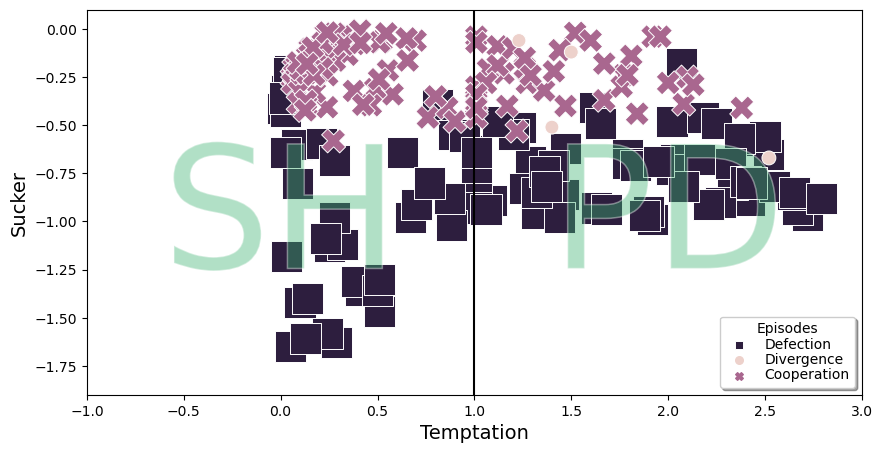

In [148]:
df_episodic_pd['game'] = 'PD'
df_episodic_sh['game'] = 'SH'
df_episodic_pd['model'] = 'episodic'
df_all_plot = pd.concat([df_episodic_pd, df_episodic_sh], ignore_index=True)
df_all_plot.temptation = df_all_plot.temptation/df_all_plot.reward
df_all_plot.sucker = df_all_plot.sucker/df_all_plot.reward
df_all_plot['new_reward'] = 1.0
df_all_plot.loc[df_all_plot.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_all_plot.loc[df_all_plot.isna().any(axis=1), 'agent2_final_strategy'] = -1

plt.figure(figsize=(10, 5))
ax = sns.scatterplot(data=df_all_plot.loc[df_all_plot.model=='episodic'].sort_values(by=['agent1_final_strategy'],ascending=False), 
                     y='sucker', x='temptation', 
                    hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[100,300,500], 
                    linewidth=0.7, alpha=1, style="agent1_final_strategy", markers=['o','X','s'])

lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='lower right', shadow=True)

plt.vlines(1, -2, 10, 'black')
# plt.hlines(0, -10, 10, 'black')

t = ax.text(2, -1, "PD", alpha = .1, animated = True, fontsize = 123, ha = "center", va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.4)])

t = ax.text(0, -1, "SH", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.4)])


plt.xlim(-1,3)
plt.ylim(-1.9,0.1)
plt.xlabel('Temptation', fontsize=14)
plt.ylabel('Sucker', fontsize=14)

#change the marker size manually for both lines
for i in lgnd.legendHandles:
    i._sizes = [30]

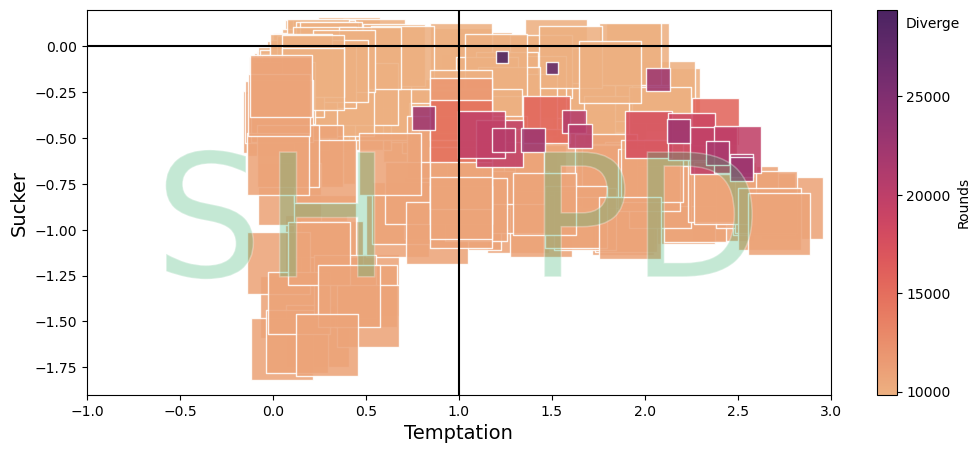

In [225]:
df_all_plot.loc[df_all_plot['agent1_strategy'].isnull(), 'agent1_strategy'] = 25000

df_all_plot['size'] = 5000
df_all_plot.loc[df_all_plot['agent1_strategy']>=15000, 'size'] = 3000
df_all_plot.loc[df_all_plot['agent1_strategy']>=20000, 'size'] = 1000
df_all_plot.loc[df_all_plot['agent1_strategy']>=25000, 'size'] = 500
df_all_plot.loc[df_all_plot['agent1_strategy']>=30000, 'size'] = 100


plt.figure(figsize=(12, 5))
ax = sns.scatterplot(data=df_all_plot.sort_values(by=['agent1_strategy'],ascending=True), y='sucker', x='temptation', 
                hue="agent1_strategy", size="size", sizes=(77, 2000), 
                linewidth=1, marker='s', alpha=0.88, palette='flare')
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.14, shadow=True)

for i in lgnd.legendHandles:
    i._sizes = [30]
    
plt.vlines(1, -2, 10, 'black')
plt.hlines(0, -10, 10, 'black')

t = ax.text(2, -1, "PD", alpha = .1, animated = True,
       fontsize = 123,      # Size
       ha = "center", # Horizontal alignment
       va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

t = ax.text(0, -1, "SH", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

ax.text(3.4, 0.1, "Diverge", color = "black")

plt.xlim(-1,3)
plt.ylim(-1.9,0.2)
    
norm = plt.Normalize(df_all_plot['agent1_strategy'].min(), df_all_plot['agent1_strategy'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='Rounds', ticks=[5000, 10000, 15000,20000,25000,30000])
plt.xlabel('Temptation', fontsize=14)
plt.ylabel('Sucker', fontsize=14)

plt.show()

# Explore SH

In [10]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)
temptation, sucker, punishment = temptation/reward, sucker/reward, punishment/reward
reward = reward/reward

np.random.seed(42)
N = 100
x = np.ones(N)
reward_1 = 1 * x
punishment_1 = 0 * x
sucker_1 = np.round(np.random.uniform(-1+0.02, punishment_1-0.01, N), decimals=2)
temptation_1 = np.round(np.random.uniform(2*punishment_1-sucker_1, reward_1-0.01, N), decimals=2)

reward = np.concatenate((reward, reward_1))
punishment = np.concatenate((punishment, punishment_1))
temptation = np.concatenate((temptation, temptation_1))
sucker = np.concatenate((sucker, sucker_1))

np.random.seed(42)
N = 30
x = np.ones(N)
reward_2 = 1 * x
punishment_2 = 0 * x
sucker_2 = np.round(np.random.uniform(-1.25, -0.5, N), decimals=2)
temptation_2 = np.round(np.random.uniform(0.4, 0.6, N), decimals=2)

reward = np.concatenate((reward, reward_2))
punishment = np.concatenate((punishment, punishment_2))
temptation = np.concatenate((temptation, temptation_2))
sucker = np.concatenate((sucker, sucker_2))

reward = np.round(reward, decimals=2)
punishment = np.round(punishment, decimals=2)
temptation = np.round(temptation, decimals=2)
sucker = np.round(sucker, decimals=2)

k = 1000
config['h'] = 5
config['n_episodes'] = 30000  # convergent threshold
config['epsilon_decay'] = 0.995
thresh_strategy = k * config['min_epsilon'] + 5
thresh_network = k/100
thresh_reward = 1
thresh = (thresh_strategy, thresh_reward, thresh_network)

In [11]:
df_normal_sh_2 = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            with HiddenPrints():
                env.play(agent1, agent2, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_normal_sh_2.loc[len(df_normal_sh_2.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

230it [2:06:23, 32.97s/it]


In [12]:
df_alter_sh_2 = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            TwoAgentSimulation.two_agent_alter_learning(agent1, agent2, config_obj, env, k)
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_alter_sh_2.loc[len(df_alter_sh_2.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                           convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                           float(torch.sum(agent1.own_memory)/agent1.play_times),
                                           round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                           float(torch.sum(agent2.own_memory)/agent2.play_times)]

230it [1:32:06, 24.03s/it]


In [13]:

df_episodic_sh_2 = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent1_updating_times', 'agent2_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    config['epsilon_decay'] = 0.995
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agents = {}
        agents[0], agents[1] = agent1, agent2 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.015, update_times=10, episodic_flag=True, sg_flag=False)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_episodic_sh_2.loc[len(df_episodic_sh_2.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            agents[0].updating_times[1], agents[1].updating_times[0]]

230it [2:14:03, 34.97s/it]


In [197]:
df_normal_sh_2['agent1_updating_times'] = df_normal_sh_2[['agent1_strategy','agent1_reward']].max(axis=1) - config['batch_size']
df_normal_sh_2['agent2_updating_times'] = df_normal_sh_2[['agent2_strategy','agent2_reward']].max(axis=1) - config['batch_size']
df_alter_sh_2['agent1_updating_times'] = (df_alter_sh_2[['agent1_strategy','agent1_reward']].max(axis=1))/4
df_alter_sh_2['agent2_updating_times'] = (df_alter_sh_2[['agent2_strategy','agent2_reward']].max(axis=1))/4
df_normal_sh_2['model'] = 'normal'
df_alter_sh_2['model'] = 'alternate'
df_episodic_sh_2['model'] = 'episodic'
df_sh_2 = pd.concat([df_normal_sh_2, df_alter_sh_2],ignore_index=True)
df_sh_2 = pd.concat([df_sh_2, df_episodic_sh_2],ignore_index=True)

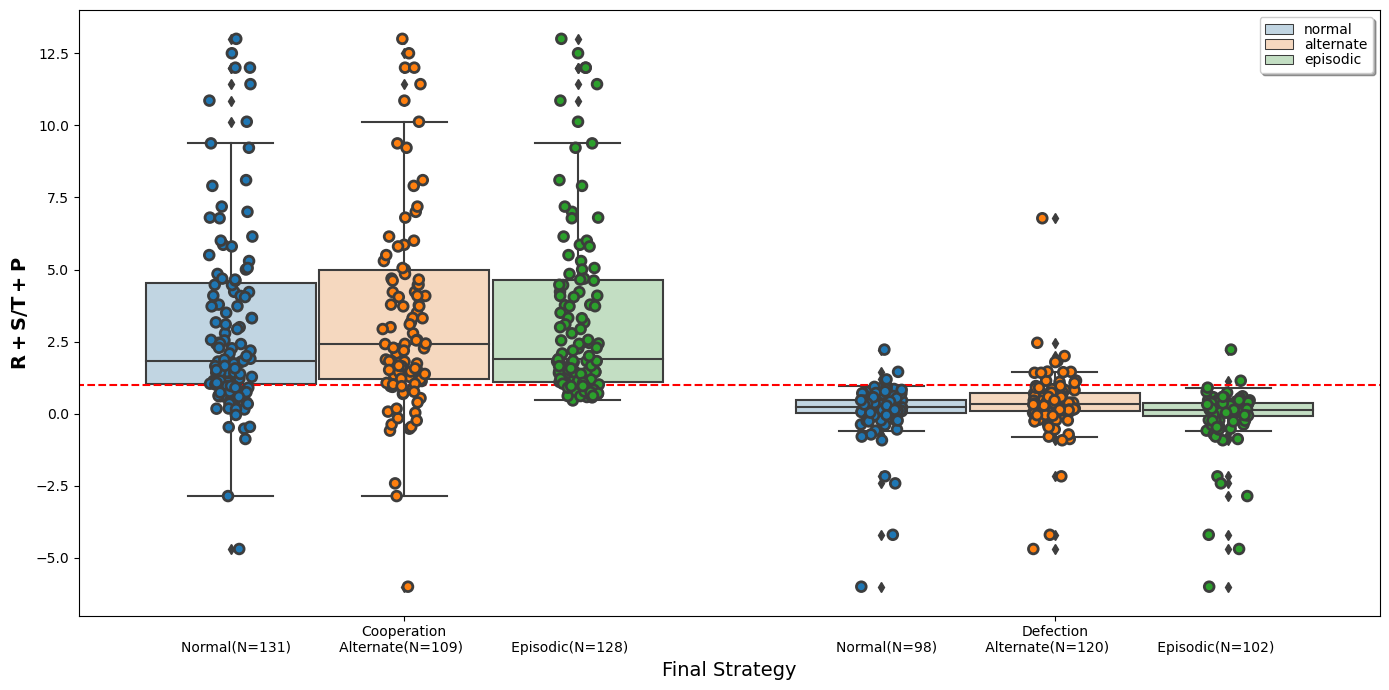

In [207]:
df_sh_plot_2 = df_sh_2.copy()
df_sh_plot_2.dropna(inplace=True)
df_sh_plot_2['R+S/T+P'] = (df_sh_plot_2['reward'] + df_sh_plot_2['sucker']) / (df_sh_plot_2['temptation'] + df_sh_plot_2['punishment'])
df_sh_plot_noraml = df_sh_plot_2.loc[df_sh_plot_2.model=='normal']
df_sh_plot_altern = df_sh_plot_2.loc[df_sh_plot_2.model=='alternate']
df_sh_plot_episod = df_sh_plot_2.loc[df_sh_plot_2.model=='episodic']

fig = plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_sh_plot_2, x="agent2_final_strategy", y="R+S/T+P", hue="model")
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent2_final_strategy', y = 'R+S/T+P',  hue='model', data = df_sh_plot_2, marker='o',
              size=7, linewidth=2, dodge=True)
plt.hlines(1, -10, 10, 'red', '--')
plt.xlim(-0.5,1.5)
plt.ylim(-7,14)
ax.set_xticks([0, 1])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_sh_plot_noraml['agent2_final_strategy']==0)})           Alternate(N={sum(df_sh_plot_altern['agent2_final_strategy']==0)})           Episodic(N={sum(df_sh_plot_episod['agent2_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_sh_plot_noraml['agent2_final_strategy']==1)})           Alternate(N={sum(df_sh_plot_altern['agent2_final_strategy']==1)})           Episodic(N={sum(df_sh_plot_episod['agent2_final_strategy']==1)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{R+S/T+P}$', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

plt.tight_layout()
fig.savefig('images/2_agent_SG_strategy_smallr.png', dpi=fig.dpi)


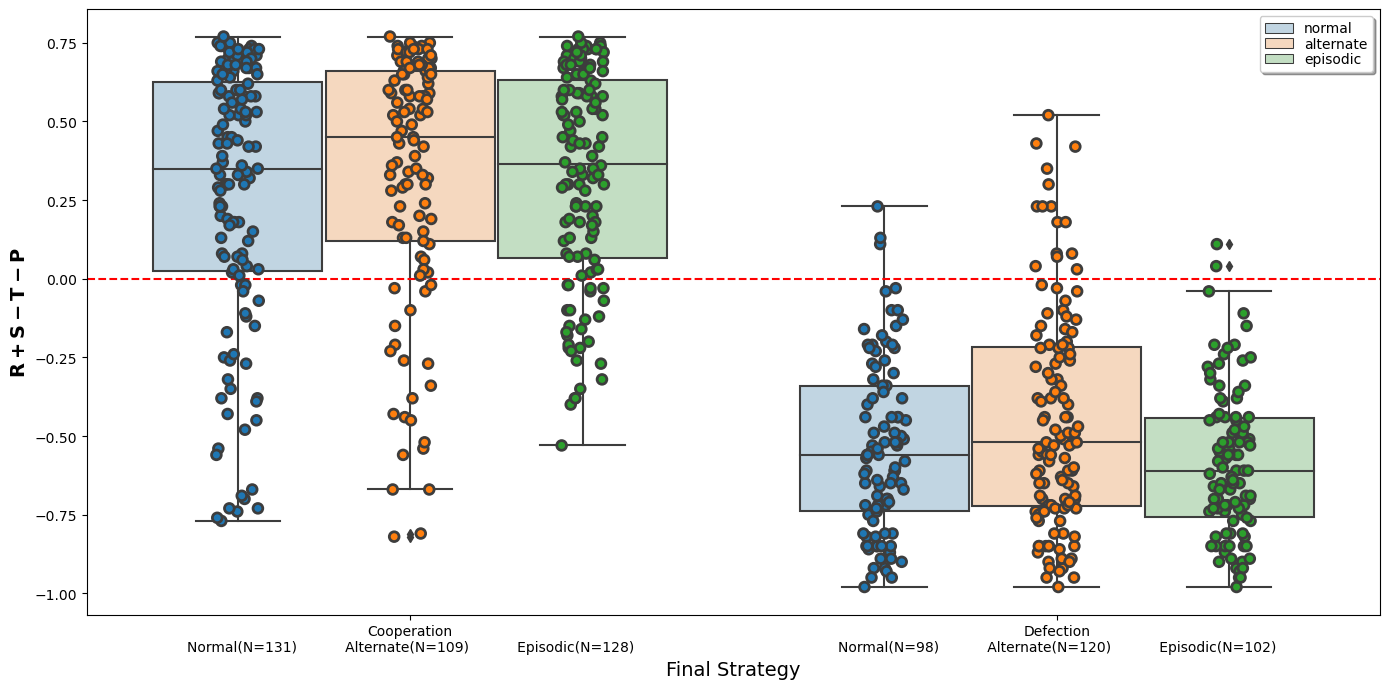

In [209]:
df_sh_plot_2['R+S-T-P'] = df_sh_plot_2['reward'] + df_sh_plot_2['sucker'] - df_sh_plot_2['temptation'] - df_sh_plot_2['punishment']
df_sh_plot_noraml = df_sh_plot_2.loc[df_sh_plot_2.model=='normal']
df_sh_plot_altern = df_sh_plot_2.loc[df_sh_plot_2.model=='alternate']
df_sh_plot_episod = df_sh_plot_2.loc[df_sh_plot_2.model=='episodic']

fig = plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df_sh_plot_2, x="agent2_final_strategy", y="R+S-T-P", hue="model")
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'agent2_final_strategy', y = 'R+S-T-P',  hue='model', data = df_sh_plot_2, marker='o',
              size=7, linewidth=2, dodge=True)
plt.hlines(0, -10, 10, 'red', '--')
plt.xlim(-0.5,1.5)
ax.set_xticks([0, 1])
ax.set_xticklabels([f"Cooperation\nNormal(N={sum(df_sh_plot_noraml['agent2_final_strategy']==0)})           Alternate(N={sum(df_sh_plot_altern['agent2_final_strategy']==0)})           Episodic(N={sum(df_sh_plot_episod['agent2_final_strategy']==0)})", 
                    f"Defection\nNormal(N={sum(df_sh_plot_noraml['agent2_final_strategy']==1)})           Alternate(N={sum(df_sh_plot_altern['agent2_final_strategy']==1)})           Episodic(N={sum(df_sh_plot_episod['agent2_final_strategy']==1)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{R+S-T-P}$', fontsize=14)
# plt.legend(loc='lower right', shadow=True)
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines[:3], labels[:3], scatterpoints=1, frameon=True, labelspacing=.1, markerscale=.14, shadow=True)

plt.tight_layout()
fig.savefig('images/2_agent_SG_strategy_smallr.png', dpi=fig.dpi)


In [160]:
df_sh_2[df_sh_2.isna().any(axis=1)]

,agent1_strategy,agent1_reward,agent2_strategy,agent2_reward,temptation,reward,punishment,sucker,agent1_final_strategy,agent1_defection_ratio,agent2_final_strategy,agent2_defection_ratio,agent1_updating_times,agent2_updating_times,model
183,29000.0,NaN,NaN,NaN,0.98,1.0,0.0,-0.92,-1.0,0.158300,-1.0,0.091400,28936.0,NaN,normal
395,NaN,30000.0,NaN,29000.0,0.90,1.0,0.0,-0.45,0.0,0.011567,0.0,0.012233,7500.0,7250.0,alternative


Text(0.5, 1.0, 'Episodic DRQN')

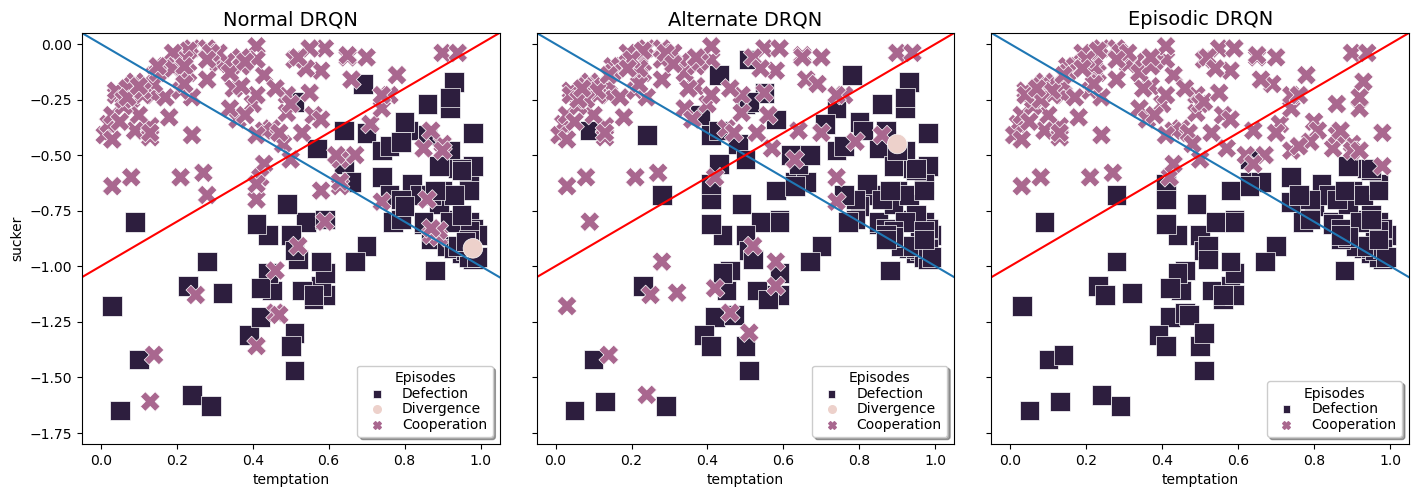

In [211]:
df_normal_sh_2.loc[df_normal_sh_2.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_normal_sh_2.loc[df_normal_sh_2.isna().any(axis=1), 'agent2_final_strategy'] = -1

df_alter_sh_2.loc[df_alter_sh_2.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_alter_sh_2.loc[df_alter_sh_2.isna().any(axis=1), 'agent2_final_strategy'] = -1

df_episodic_sh_2.loc[df_episodic_sh_2.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_episodic_sh_2.loc[df_episodic_sh_2.isna().any(axis=1), 'agent2_final_strategy'] = -1

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

sns.scatterplot(ax=axes[0], data=df_normal_sh_2.sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='lower right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
x = np.linspace(-0.5, 1.5, 100)
axes[0].plot(x, -x)
axes[0].plot(x, x-1, 'r')
    
sns.scatterplot(ax=axes[1], data=df_alter_sh_2.sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[1].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='lower right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
axes[1].plot(x, -x)
axes[1].plot(x, x-1, 'r')
    
sns.scatterplot(ax=axes[2], data=df_episodic_sh_2.sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[2].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='lower right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
axes[2].plot(x, -x)
axes[2].plot(x, x-1, 'r')

axes[0].axis(xmin=-0.05,xmax=1.05,ymin=-1.8,ymax=0.05)
axes[1].axis(xmin=-0.05,xmax=1.05,ymin=-1.8,ymax=0.05)
axes[2].axis(xmin=-0.05,xmax=1.05,ymin=-1.8,ymax=0.05)
axes[0].set_title('Normal DRQN', fontsize=14)
axes[1].set_title('Alternate DRQN', fontsize=14)
axes[2].set_title('Episodic DRQN', fontsize=14)
# fig.savefig('images/2_agent_SG_strategy.png', dpi=fig.dpi)


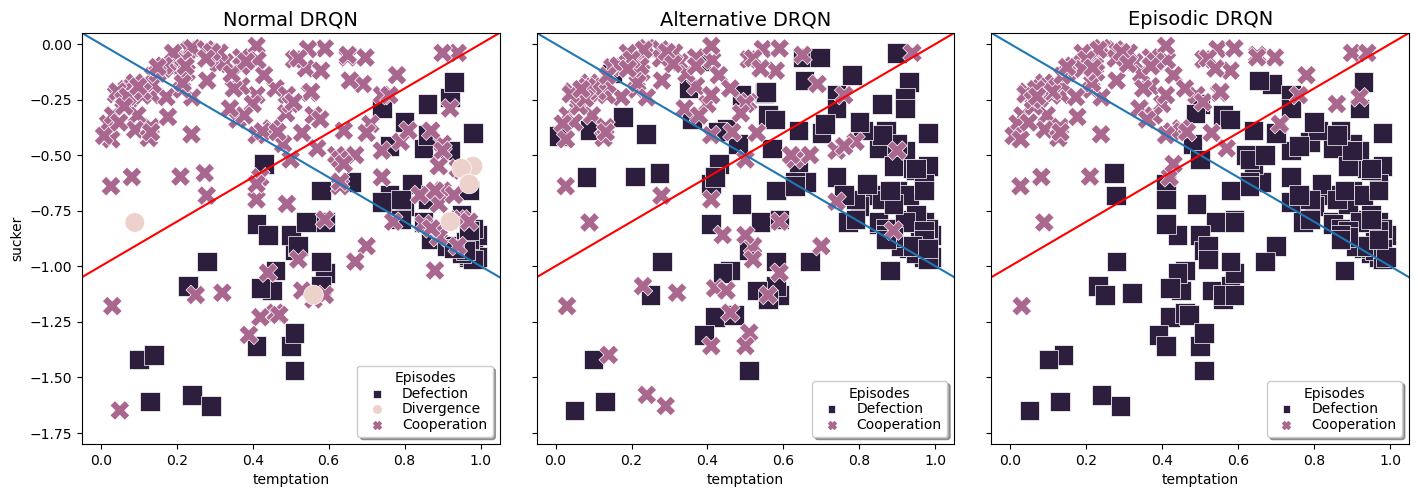

In [495]:
df_normal_sh_.loc[df_normal_sh_.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_normal_sh_.loc[df_normal_sh_.isna().any(axis=1), 'agent2_final_strategy'] = -1

df_alter_sh_.loc[df_episodic_sh_.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_alter_sh_.loc[df_episodic_sh_.isna().any(axis=1), 'agent2_final_strategy'] = -1

df_episodic_sh_.loc[df_episodic_sh_.isna().any(axis=1), 'agent1_final_strategy'] = -1
df_episodic_sh_.loc[df_episodic_sh_.isna().any(axis=1), 'agent2_final_strategy'] = -1

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

sns.scatterplot(ax=axes[0], data=df_normal_sh_.sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='lower right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]

x = np.linspace(-0.5, 1.5, 100)
axes[0].plot(x, -x)
axes[0].plot(x, x-1, 'r')


sns.scatterplot(ax=axes[1], data=df_alter_sh_.sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[1].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='lower right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
axes[1].plot(x, -x)
axes[1].plot(x, x-1, 'r')

    
sns.scatterplot(ax=axes[2], data=df_episodic_sh_.sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[2].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='lower right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
axes[2].plot(x, -x)
axes[2].plot(x, x-1, 'r')


axes[0].axis(xmin=-0.05,xmax=1.05,ymin=-1.8,ymax=0.05)
axes[1].axis(xmin=-0.05,xmax=1.05,ymin=-1.8,ymax=0.05)
axes[2].axis(xmin=-0.05,xmax=1.05,ymin=-1.8,ymax=0.05)
axes[0].set_title('Normal DRQN', fontsize=14)
axes[1].set_title('Alternative DRQN', fontsize=14)
axes[2].set_title('Episodic DRQN', fontsize=14)
fig.savefig('images/2_agent_sh_strategy_compare.png', dpi=fig.dpi)
